
 1. CHARGEMENT DES DONNÉES 

Dimensions : (164501, 77)
 Aucune valeur manquante détectée.

Valeurs manquantes :
|                    |   Flow_Duration |   Tot_Fwd_Pkts |   Tot_Bwd_Pkts |   TotLen_Fwd_Pkts |   TotLen_Bwd_Pkts |   Fwd_Pkt_Len_Max |   Fwd_Pkt_Len_Min |   Fwd_Pkt_Len_Mean |   Fwd_Pkt_Len_Std |   Bwd_Pkt_Len_Max |   Bwd_Pkt_Len_Min |   Bwd_Pkt_Len_Mean |   Bwd_Pkt_Len_Std |   Flow_Byts/s |   Flow_Pkts/s |   Flow_IAT_Mean |   Flow_IAT_Std |   Flow_IAT_Max |   Flow_IAT_Min |   Fwd_IAT_Tot |   Fwd_IAT_Mean |   Fwd_IAT_Std |   Fwd_IAT_Max |   Fwd_IAT_Min |   Bwd_IAT_Tot |   Bwd_IAT_Mean |   Bwd_IAT_Std |   Bwd_IAT_Max |   Bwd_IAT_Min |   Fwd_PSH_Flags |   Bwd_PSH_Flags |   Fwd_URG_Flags |   Bwd_URG_Flags |   Fwd_Header_Len |   Bwd_Header_Len |   Fwd_Pkts/s |   Bwd_Pkts/s |   Pkt_Len_Min |   Pkt_Len_Max |   Pkt_Len_Mean |   Pkt_Len_Std |   Pkt_Len_Var |   FIN_Flag_Cnt |   SYN_Flag_Cnt |   RST_Flag_Cnt |   PSH_Flag_Cnt |   ACK_Flag_Cnt |   URG_Flag_Cnt |   CWE_Flag_Count |   ECE

,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,Flow_Byts/s,Flow_Pkts/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Tot,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Tot,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Len,Bwd_Header_Len,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Min,Pkt_Len_Max,Pkt_Len_Mean,Pkt_Len_Std,Pkt_Len_Var,FIN_Flag_Cnt,SYN_Flag_Cnt,RST_Flag_Cnt,PSH_Flag_Cnt,ACK_Flag_Cnt,URG_Flag_Cnt,CWE_Flag_Count,ECE_Flag_Cnt,Down/Up_Ratio,Pkt_Size_Avg,Fwd_Seg_Size_Avg,Bwd_Seg_Size_Avg,Fwd_Byts/b_Avg,Fwd_Pkts/b_Avg,Fwd_Blk_Rate_Avg,Bwd_Byts/b_Avg,Bwd_Pkts/b_Avg,Bwd_Blk_Rate_Avg,Subflow_Fwd_Pkts,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Cat
0,75,1,1,982.000000,1430.000000,982.000000,982.000000,982.000000,0.000000,1430.000000,1430.000000,1430.000000,0.000000,32160000.000000,26666.666667,75.000000,0.000000,75.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,8,8,13333.333333,13333.333333,982.000000,1430.000000,1280.666667,258.652921,66901.333333,0,0,0,0,0,0,0,0,1.000000,1921.000000,982.000000,1430.000000,0,0,0,0,0,0,1,982,1,1430,-1,-1,1,0,0.000000,0.000000,0.000000,0.000000,75.000000,0.000000,75.000000,75.000000,Mirai
1,5310,1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,564.971751,2655.000000,2261.327486,4254.000000,1056.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5310.000000,5310.000000,0.000000,5310.000000,5310.000000,0,0,0,0,20,44,188.323917,376.647834,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,2.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,1,0,2,0,-1,14600,0,0,0.000000,0.000000,0.000000,0.000000,2655.000000,2261.327486,4254.000000,1056.000000,DoS
2,141,0,3,0.000000,2806.000000,0.000000,0.000000,0.000000,0.000000,1388.000000,30.000000,935.333333,784.041666,19900709.219858,21276.595745,70.500000,0.707107,71.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,141.000000,70.500000,0.707107,71.000000,70.000000,0,0,0,0,0,96,0.000000,21276.595745,30.000000,1388.000000,1048.500000,679.000000,461041.000000,0,0,0,0,1,0,0,0,0.000000,1398.000000,0.000000,935.333333,0,0,0,0,0,0,0,0,3,2806,-1,1869,0,0,0.000000,0.000000,0.000000,0.000000,70.500000,0.707107,71.000000,70.000000,Scan



 2. ANALYSE EXPLORATOIRE 


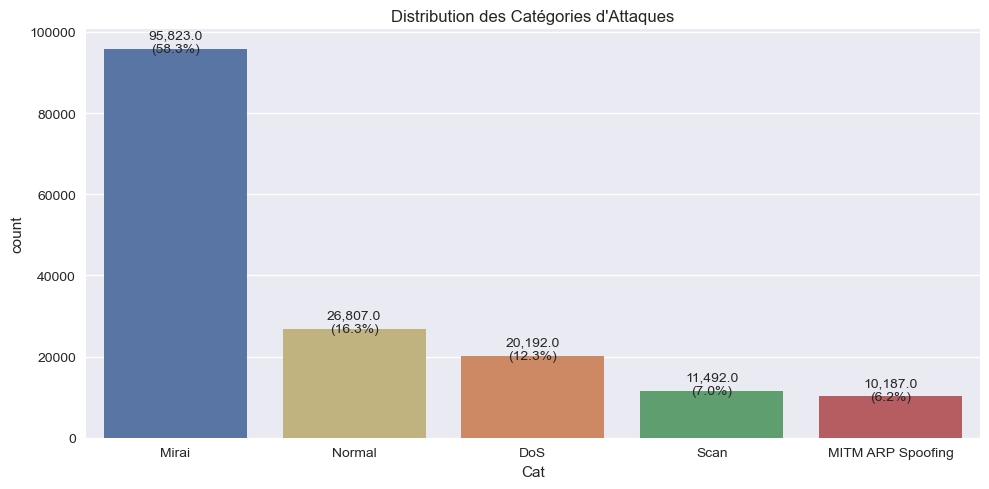

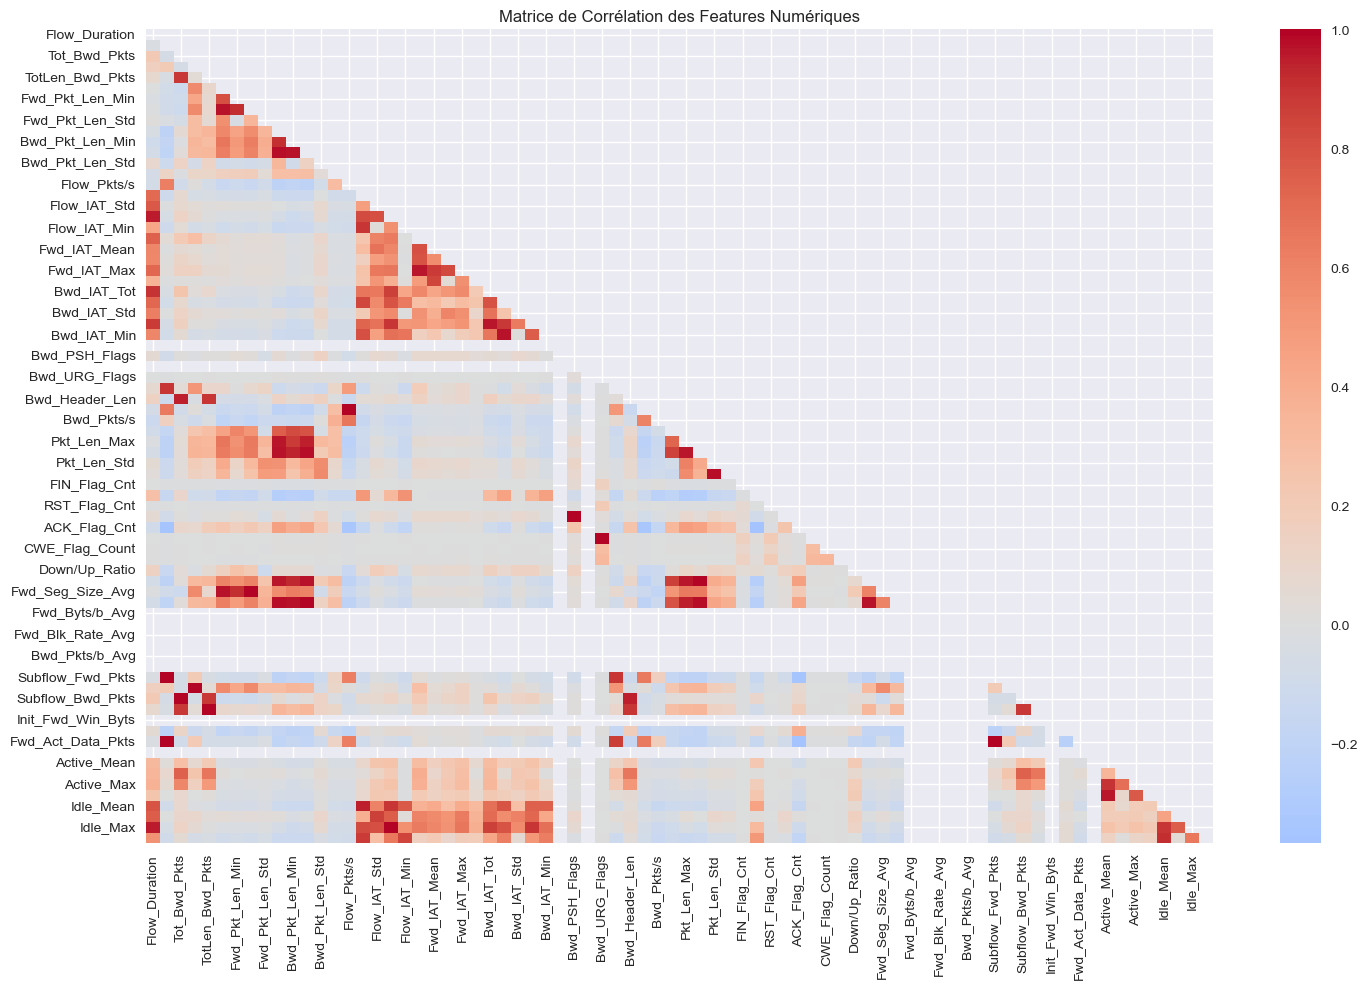


 3. PRÉPARATION DES DONNÉES 


,Encoded,Original,Count,Percentage
0,0,DoS,20192,12.3%
1,1,MITM ARP Spoofing,10187,6.2%
2,2,Mirai,95823,58.3%
3,3,Normal,26807,16.3%
4,4,Scan,11492,7.0%



 4. FEATURE ENGINEERING 


,Moyenne,Écart-type
Flow_Duration,-0.00,1.00
Tot_Fwd_Pkts,-0.00,1.00
Tot_Bwd_Pkts,0.00,1.00
TotLen_Fwd_Pkts,-0.00,1.00
TotLen_Bwd_Pkts,0.00,1.00
Fwd_Pkt_Len_Max,-0.00,1.00
Fwd_Pkt_Len_Min,-0.00,1.00
Fwd_Pkt_Len_Mean,-0.00,1.00
Fwd_Pkt_Len_Std,-0.00,1.00
Bwd_Pkt_Len_Max,0.00,1.00


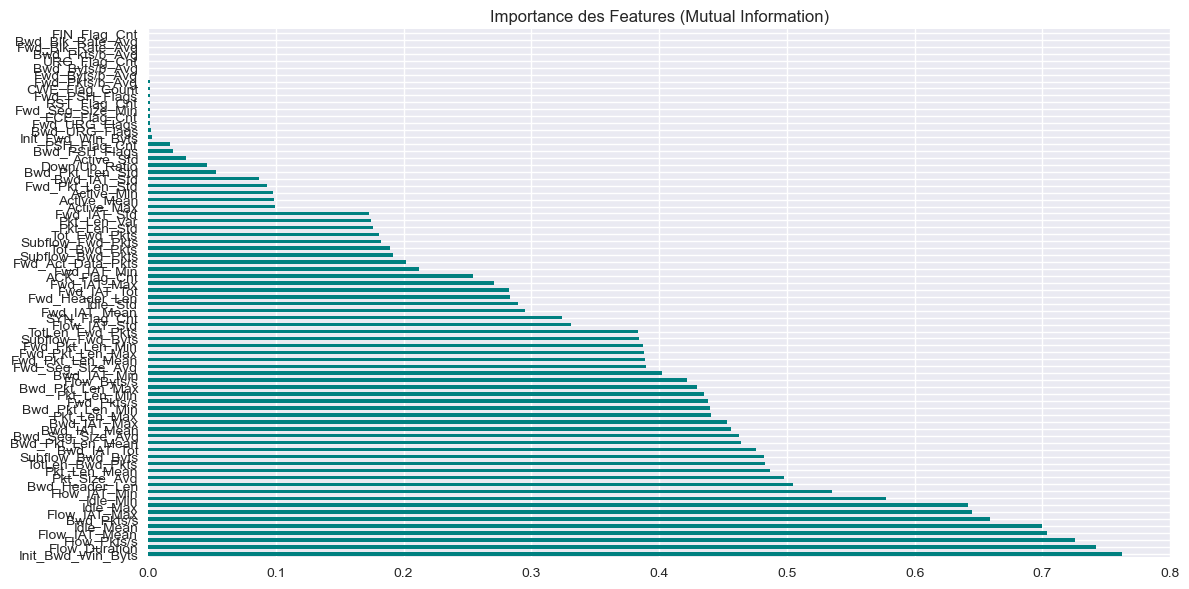


Variables supprimées pour redondance : 28
🔻 ['Fwd_Pkt_Len_Mean', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean', 'Flow_IAT_Max', 'Fwd_IAT_Max', 'Bwd_IAT_Tot', 'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Bwd_Header_Len', 'Fwd_Pkts/s', 'Pkt_Len_Max', 'Pkt_Len_Mean', 'Pkt_Len_Var', 'PSH_Flag_Cnt', 'URG_Flag_Cnt', 'Pkt_Size_Avg', 'Fwd_Seg_Size_Avg', 'Bwd_Seg_Size_Avg', 'Subflow_Fwd_Pkts', 'Subflow_Fwd_Byts', 'Subflow_Bwd_Pkts', 'Subflow_Bwd_Byts', 'Fwd_Act_Data_Pkts', 'Active_Max', 'Active_Min', 'Idle_Mean', 'Idle_Max', 'Idle_Min']

 5. SÉPARATION TRAIN/TEST 


,Train,Test,Diff (%)
0,12.3%,12.3%,0.0%
1,6.2%,6.2%,0.0%
2,58.3%,58.3%,0.0%
3,16.3%,16.3%,0.0%
4,7.0%,7.0%,0.0%



=== 6. SAUVEGARDE ===

 Sauvegarde terminée avec succès.
- 131,600 échantillons d'entraînement
- 32,901 échantillons de test
- 5 classes: DoS, MITM ARP Spoofing, Mirai, Normal, Scan


In [15]:
# importations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
import joblib
import warnings
import json

#  Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')  
pd.set_option('display.max_columns', 100)

RANDOM_STATE = 42
TEST_SIZE = 0.2
DATA_PATH = "dataset_cleaned.csv"

PALETTE = {
    'Mirai': '#4C72B0',
    'DoS': '#DD8452', 
    'Scan': '#55A868',
    'Normal': '#CCB974',
    'MITM ARP Spoofing': '#C44E52'
}

#  ********* CHARGEMENT DES DONNÉES *********

print("\n\033[1m 1. CHARGEMENT DES DONNÉES \033[0m")
df = pd.read_csv(DATA_PATH, sep=";")
df.drop_duplicates(inplace=True)
df.fillna(method="ffill", inplace=True)

print(f"\nDimensions : {df.shape}")
#  Vérification des valeurs manquantes
missing = df.isnull().sum()
missing_total = missing.sum()

if missing_total == 0:
    print(" Aucune valeur manquante détectée.")
else:
    print(f" {missing_total} valeurs manquantes détectées au total.")
    print(missing[missing > 0].to_frame("Nombre").sort_values(by="Nombre", ascending=False))

print("\nValeurs manquantes :")
print(df.isnull().sum().to_frame('Valeurs manquantes').T.to_markdown())

def smart_display(df, n=3):
    display(df.head(n).style.background_gradient(subset=df.select_dtypes(include=np.number).columns, cmap='Blues').set_caption(f"Aperçu des {n} premières lignes (valeurs numériques normalisées)"))
    
smart_display(df)

# ****** ANALYSE EXPLORATOIRE ********
print("\n\033[1m 2. ANALYSE EXPLORATOIRE \033[0m")

plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Cat', data=df, order=df['Cat'].value_counts().index, palette=PALETTE)
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + total*0.01, f'{height:,}\n({height/total:.1%})', ha='center', va='center', fontsize=10)
plt.title("Distribution des Catégories d'Attaques")
plt.tight_layout()
plt.savefig("class_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

corr_matrix = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(15, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0)
plt.title("Matrice de Corrélation des Features Numériques")
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


# ******* PRÉPARATION DES DONNÉES ********
print("\n\033[1m 3. PRÉPARATION DES DONNÉES \033[0m")

X = df.drop("Cat", axis=1)
y_raw = df["Cat"]

encoder = LabelEncoder()
y = encoder.fit_transform(y_raw)
class_names = encoder.classes_

class_map = pd.DataFrame({'Encoded': range(len(class_names)),'Original': class_names,'Count': [sum(y_raw == name) for name in class_names],
    'Percentage': [f"{sum(y_raw == name)/len(y_raw):.1%}" for name in class_names]
})

display(class_map.style.bar(subset=['Count'], color='#7B9EB0'))
class_map.to_csv("class_mapping.csv", index=False)
joblib.dump(encoder, "label_encoder.joblib")

# ******** FEATURE ENGINEERING ********
print("\n\033[1m 4. FEATURE ENGINEERING \033[0m")

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
joblib.dump(scaler, "feature_scaler.joblib")

# Statistiques post-standardisation
stats = pd.DataFrame({'Moyenne': X_scaled.mean(), 'Écart-type': X_scaled.std()})
display(stats.style.format("{:.2f}").background_gradient(cmap='Blues'))

# Calcul des scores MI 
mi_scores = mutual_info_classif(X_scaled, y, random_state=RANDOM_STATE)
mi_series = pd.Series(mi_scores, name="MI Scores", index=X_scaled.columns).sort_values(ascending=False)
mi_series.to_csv("mutual_info_scores.csv")

# Visualisation uniquement
plt.figure(figsize=(12, 6))
mi_series.plot(kind='barh', color='teal')
plt.title("Importance des Features (Mutual Information)")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# Suppression des features trop corrélées
corr_matrix = X_scaled.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones_like(corr_matrix), k=1).astype(bool))
to_drop_corr = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.9)]
X_dedup = X_scaled.drop(columns=to_drop_corr)
print(f"\nVariables supprimées pour redondance : {len(to_drop_corr)}")
print("🔻", to_drop_corr)

X_selected = X_dedup.copy()
selected_features = list(X_selected.columns)

with open("selected_features.json", "w") as f:
    json.dump(selected_features, f, indent=4)


# ************ SÉPARATION TRAIN/TEST *********
print("\n\033[1m 5. SÉPARATION TRAIN/TEST \033[0m")

X_train, X_test, y_train, y_test = train_test_split( X_selected, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
test_dist = pd.Series(y_test).value_counts(normalize=True).sort_index()
dist_df = pd.DataFrame({'Train': train_dist,'Test': test_dist,'Diff (%)': ((train_dist - test_dist)/train_dist*100).abs()})
display(dist_df.style.format({'Train': '{:.1%}', 'Test': '{:.1%}', 'Diff (%)': '{:.1f}%'}).background_gradient(subset=['Diff (%)'], cmap='YlOrBr'))

# === 6. SAUVEGARDE FINALE ===
print("\n\033[1m=== 6. SAUVEGARDE ===\033[0m")

X_train.to_parquet("X_train.parquet")
X_test.to_parquet("X_test.parquet")
pd.Series(y_train, name='target').to_csv("y_train.csv", index=False)
pd.Series(y_test, name='target').to_csv("y_test.csv", index=False)

metadata = {
    'date_created': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'original_shape': df.shape,
    'features': selected_features,
    'dropped_corr_features': to_drop_corr,
    'classes': list(class_names),
    'test_size': TEST_SIZE,
    'random_state': RANDOM_STATE
}
with open("metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("\n\033[1m Sauvegarde terminée avec succès.\033[0m")
print(f"- {len(X_train):,} échantillons d'entraînement")
print(f"- {len(X_test):,} échantillons de test")
print(f"- {len(class_names)} classes: {', '.join(class_names)}")



=== 7. ÉQUILIBRAGE AVEC SMOTE ===


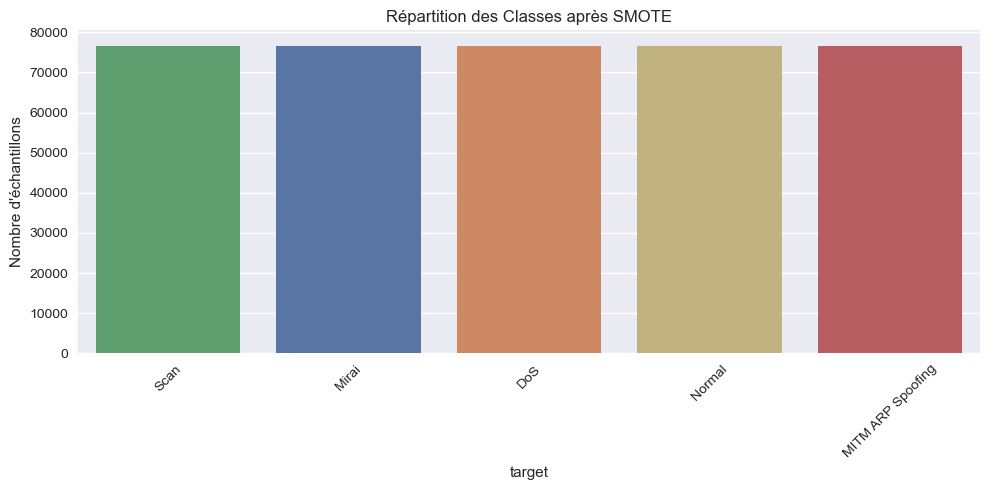


 Jeu d'entraînement équilibré : 383,290 échantillons


In [17]:
# ******** equilibrage ***********

from imblearn.over_sampling import SMOTE

print("\n\033[1m=== 7. ÉQUILIBRAGE AVEC SMOTE ===\033[0m")

# Initialisation
smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=RANDOM_STATE)

X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)


# Conversion en DataFrame pour sauvegarde
X_train_SMOTE_df = pd.DataFrame(X_train_SMOTE, columns=X_train.columns)
y_train_SMOTE_df = pd.Series(y_train_SMOTE, name='target')

#  Affichage des nouvelles proportions
smote_dist = y_train_SMOTE_df.value_counts(normalize=True).sort_index()
smote_named = y_train_SMOTE_df.map(dict(zip(range(len(class_names)), class_names)))

plt.figure(figsize=(10, 5))
sns.countplot(x=smote_named, order=smote_named.value_counts().index, palette=PALETTE)
plt.title("Répartition des Classes après SMOTE")
plt.ylabel("Nombre d'échantillons")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("train_distribution_after_SMOTE.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Jeu d'entraînement équilibré : {X_train_SMOTE.shape[0]:,} échantillons")

#  Sauvegarde du jeu équilibré
X_train_SMOTE_df.to_parquet("X_train_SMOTE.parquet")
y_train_SMOTE_df.to_csv("y_train_SMOTE.csv", index=False)

#  Mise à jour des métadonnées
metadata['balancing_SMOTE'] = {
    'strategy': 'SMOTE',
    'train_samples_after': X_train_SMOTE.shape[0],
    'class_distribution': smote_named.value_counts().to_dict()
}
with open("metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)



=== 7. ÉQUILIBRAGE AVEC RUS ===


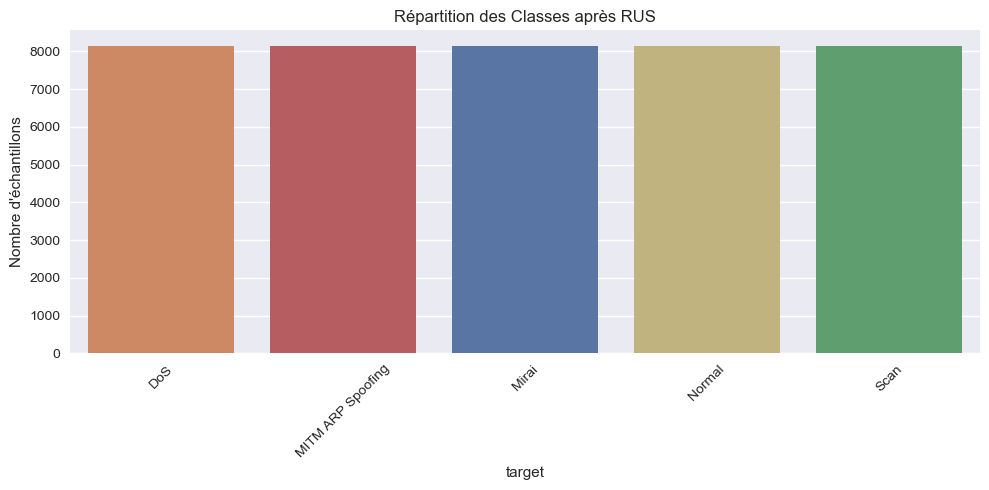


 Jeu d'entraînement équilibré (RUS) : 40,750 échantillons


In [19]:
# ***********equilibrage avec RUS ***************

from imblearn.under_sampling import RandomUnderSampler

print("\n\033[1m=== 7. ÉQUILIBRAGE AVEC RUS ===\033[0m")

# Initialisation
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

X_train_rus_df = pd.DataFrame(X_train_rus, columns=X_train.columns)
y_train_rus_df = pd.Series(y_train_rus, name='target')

#  Affichage des nouvelles proportions
rus_dist = y_train_rus_df.value_counts(normalize=True).sort_index()
rus_named = y_train_rus_df.map(dict(zip(range(len(class_names)), class_names)))

plt.figure(figsize=(10, 5))
sns.countplot(x=rus_named, palette=PALETTE)
plt.title("Répartition des Classes après RUS")
plt.ylabel("Nombre d'échantillons")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("train_distribution_after_RUS.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Jeu d'entraînement équilibré (RUS) : {X_train_rus.shape[0]:,} échantillons")

#  Sauvegarde du jeu équilibré
X_train_rus_df.to_parquet("X_train_rus.parquet")
y_train_rus_df.to_csv("y_train_rus.csv", index=False)

#  Mise à jour des métadonnées
metadata['balancing_RUS'] = {
    'strategy': 'RUS',
    'train_samples_after': X_train_rus.shape[0],
    'class_distribution': rus_named.value_counts().to_dict()
}
with open("metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)



=== 8. SÉLECTION CROISÉE MI & LASSO + EXTRACTION DES JEUX ===
 MI : 33 features sélectionnées


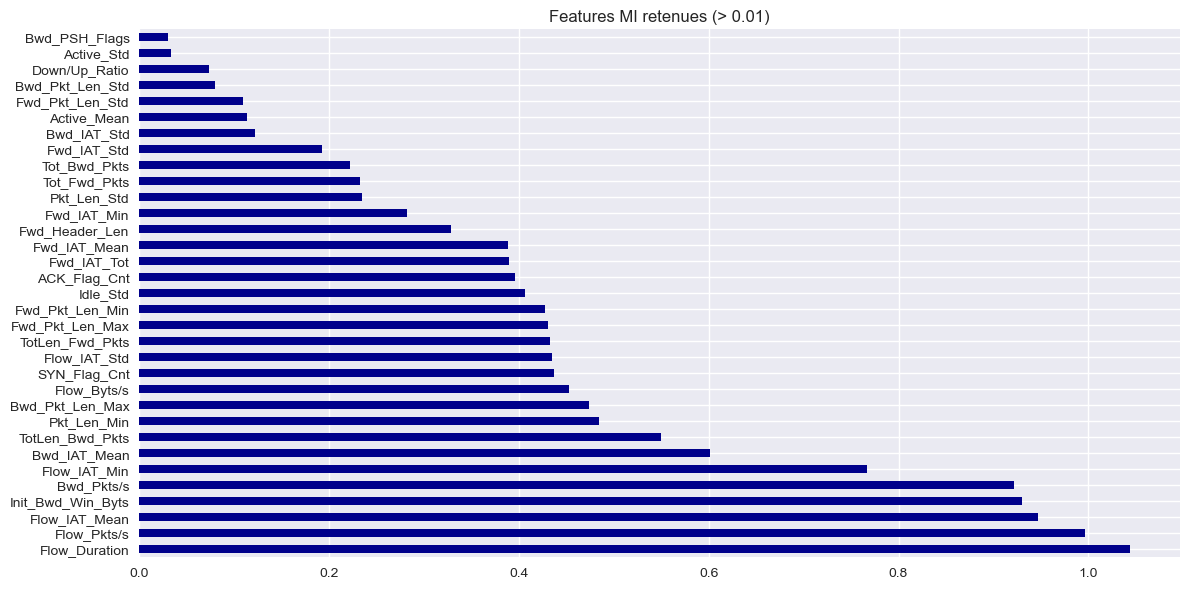

 LASSO : 38 features retenues


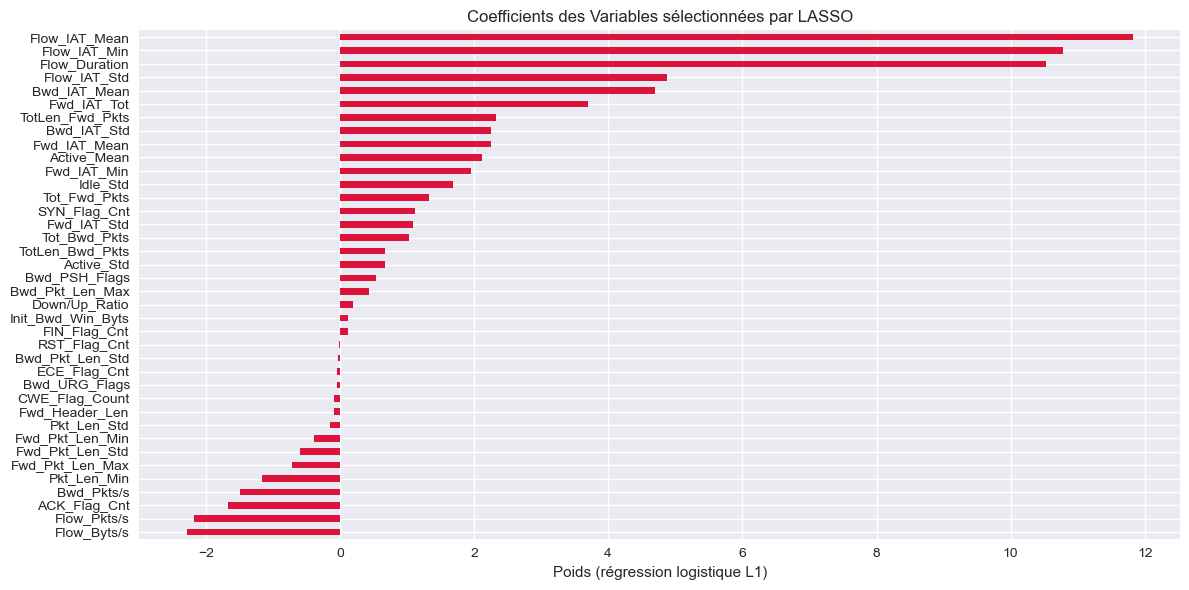

 Intersection MI ∩ LASSO : 33 features

 Tous les jeux filtrés ont été sauvegardés (MI, LASSO, Intersection)


In [21]:
from sklearn.feature_selection import mutual_info_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import json

print("\n\033[1m=== 8. SÉLECTION CROISÉE MI & LASSO + EXTRACTION DES JEUX ===\033[0m")

# selection MI
mi_scores = mutual_info_classif(X_train_SMOTE, y_train_SMOTE, random_state=RANDOM_STATE,)

mi_series = pd.Series(mi_scores, index=X_train_SMOTE.columns).sort_values(ascending=False)
THRESHOLD_MI = 0.01
mi_selected = mi_series[mi_series > THRESHOLD_MI].index.tolist()

# Sauvegarde MI
mi_series.to_csv("mi_scores_SMOTE.csv")
with open("selected_features_MI_SMOTE.json", "w") as f:
    json.dump(mi_series[mi_selected].to_dict(), f, indent=4)
print(f" MI : {len(mi_selected)} features sélectionnées")

#  Visualisation MI
plt.figure(figsize=(12, 6))
mi_series[mi_selected].plot(kind='barh', color='darkblue')
plt.title("Features MI retenues (> 0.01)")
plt.tight_layout()
plt.savefig("selected_features_MI.png", dpi=300)
plt.show()


# selection LASSO
lasso_model = LogisticRegression(
    penalty='l1',
    solver='saga',                  
    C=1.0,                          
    multi_class='multinomial',     
    max_iter=5000,                 
    random_state=RANDOM_STATE
)
#  Entraîner le modèle sur les données
lasso_model.fit(X_train_SMOTE, y_train_SMOTE_df)

selector = SelectFromModel(estimator=lasso_model)
selector.fit(X_train_SMOTE, y_train_SMOTE)

lasso_mask = selector.get_support()
lasso_selected = X_train_SMOTE.columns[lasso_mask].tolist()
lasso_coeffs = pd.Series(lasso_model.coef_[0], index=X_train_SMOTE.columns)
lasso_selected_coeffs = lasso_coeffs[lasso_mask].sort_values(key=abs, ascending=False)

# Sauvegarde LASSO
lasso_selected_dict = lasso_selected_coeffs.to_dict()
lasso_coeffs.to_csv("lasso_coefficients_SMOTE.csv")
with open("selected_features_LASSO_SMOTE.json", "w") as f:
    json.dump(lasso_selected_dict, f, indent=4)
print(f" LASSO : {len(lasso_selected)} features retenues")

#  Visualisation des coefficients LASSO retenus
plt.figure(figsize=(12, 6))
lasso_selected_coeffs.sort_values().plot(kind='barh', color='crimson')
plt.title("Coefficients des Variables sélectionnées par LASSO")
plt.xlabel("Poids (régression logistique L1)")
plt.tight_layout()
plt.savefig("selected_features_LASSO.png", dpi=300)
plt.show()


# *********** INTERSECTION **************
selected_intersection = sorted(set(mi_selected) & set(lasso_selected))
with open("selected_features_MI_LASSO_SMOTE.json", "w") as f:
    json.dump(selected_intersection, f, indent=4)
print(f" Intersection MI ∩ LASSO : {len(selected_intersection)} features")


# === EXTRACTION DES JEUX FILTRÉS ===

# MI
X_train_MI = pd.DataFrame(X_train_SMOTE, columns=X_train_SMOTE_df.columns)[mi_selected]
X_test_MI = X_test[mi_selected]
X_train_MI.to_parquet("X_train_MI.parquet")
X_test_MI.to_parquet("X_test_MI.parquet")

# LASSO
X_train_LASSO = pd.DataFrame(X_train_SMOTE, columns=X_train_SMOTE_df.columns)[lasso_selected]
X_test_LASSO = X_test[lasso_selected]
X_train_LASSO.to_parquet("X_train_LASSO.parquet")
X_test_LASSO.to_parquet("X_test_LASSO.parquet")

# Intersection
X_train_MI_LASSO = pd.DataFrame(X_train_SMOTE, columns=X_train_SMOTE_df.columns)[selected_intersection]
X_test_MI_LASSO = X_test[selected_intersection]
X_train_MI_LASSO.to_parquet("X_train_MI_LASSO.parquet")
X_test_MI_LASSO.to_parquet("X_test_MI_LASSO.parquet")

print("\n Tous les jeux filtrés ont été sauvegardés (MI, LASSO, Intersection)")



 SÉLECTION MI & LASSO (RUS)  
 MI RUS : 33 features sélectionnées


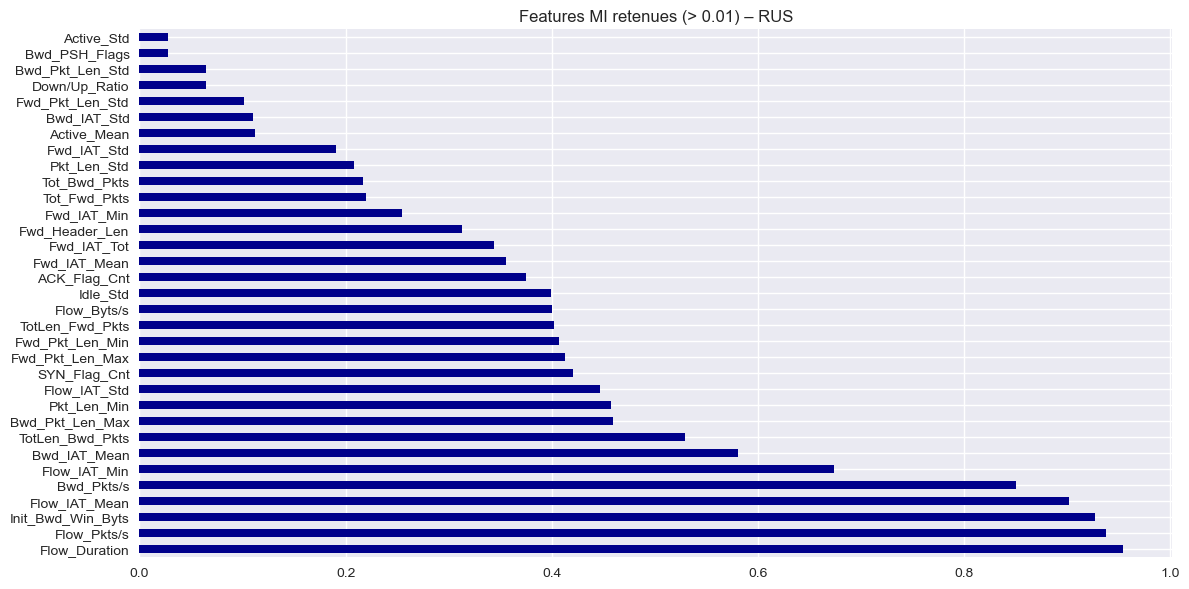

 LASSO RUS : 38 features sélectionnées


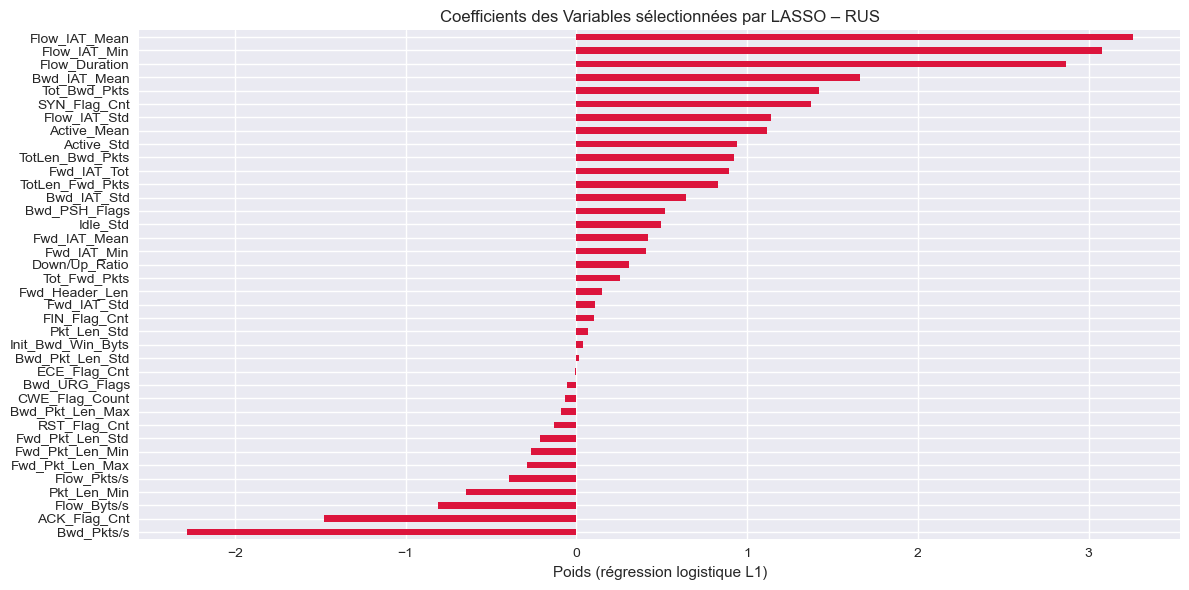

 Intersection MI ∩ LASSO RUS : 33 features

 Tous les jeux RUS filtrés ont été sauvegardés (MI, LASSO, Intersection)


In [23]:
from sklearn.feature_selection import mutual_info_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import json

print("\n\033[1m SÉLECTION MI & LASSO (RUS)  \033[0m")

# ************* MI *******************
mi_scores_rus = mutual_info_classif(
    X_train_rus_df,
    y_train_rus_df,
    random_state=RANDOM_STATE
)

mi_series_rus = pd.Series(mi_scores_rus, index=X_train_rus_df.columns).sort_values(ascending=False)
THRESHOLD_MI = 0.01
mi_selected_rus = mi_series_rus[mi_series_rus > THRESHOLD_MI].index.tolist()

# Sauvegarde MI
mi_series_rus.to_csv("mi_scores_rus.csv")
with open("selected_features_MI_rus.json", "w") as f:
    json.dump(mi_series_rus[mi_selected_rus].to_dict(), f, indent=4)
print(f" MI RUS : {len(mi_selected_rus)} features sélectionnées")

# Visualisation MI
plt.figure(figsize=(12, 6))
mi_series_rus[mi_selected_rus].plot(kind='barh', color='darkblue')
plt.title("Features MI retenues (> 0.01) – RUS")
plt.tight_layout()
plt.savefig("selected_features_MI_rus.png", dpi=300)
plt.show()


# ******** LASSO *************
lasso_model_rus = LogisticRegression(
    penalty='l1',
    solver='saga',
    C=1.0,
    multi_class='multinomial',
    max_iter=5000,
    random_state=RANDOM_STATE
)

lasso_model_rus.fit(X_train_rus_df, y_train_rus_df)

selector_rus = SelectFromModel(estimator=lasso_model_rus)
selector_rus.fit(X_train_rus_df, y_train_rus_df)

lasso_mask_rus = selector_rus.get_support()
lasso_selected_rus = X_train_rus_df.columns[lasso_mask_rus].tolist()
lasso_coeffs_rus = pd.Series(lasso_model_rus.coef_[0], index=X_train_rus_df.columns)
lasso_selected_coeffs_rus = lasso_coeffs_rus[lasso_mask_rus].sort_values(key=abs, ascending=False)

# Sauvegarde LASSO
lasso_selected_rus_dict = lasso_selected_coeffs_rus.to_dict()
lasso_coeffs_rus.to_csv("lasso_coefficients_rus.csv")
with open("selected_features_LASSO_rus.json", "w") as f:
    json.dump(lasso_selected_rus_dict, f, indent=4)
print(f" LASSO RUS : {len(lasso_selected_rus)} features sélectionnées")

# Visualisation des coefficients LASSO retenus
plt.figure(figsize=(12, 6))
lasso_selected_coeffs_rus.sort_values().plot(kind='barh', color='crimson')
plt.title("Coefficients des Variables sélectionnées par LASSO – RUS")
plt.xlabel("Poids (régression logistique L1)")
plt.tight_layout()
plt.savefig("selected_features_LASSO_rus.png", dpi=300)
plt.show()


# *********** INTERSECTION ************
selected_intersection_rus = sorted(set(mi_selected_rus) & set(lasso_selected_rus))
with open("selected_features_MI_LASSO_rus.json", "w") as f:
    json.dump(selected_intersection_rus, f, indent=4)
print(f" Intersection MI ∩ LASSO RUS : {len(selected_intersection_rus)} features")


# ******* EXTRACTION DES JEUX FILTRÉS **********

# MI
X_train_MI_rus = X_train_rus_df[mi_selected_rus]
X_test_MI_rus = X_test[mi_selected_rus]
X_train_MI_rus.to_parquet("X_train_MI_rus.parquet")
X_test_MI_rus.to_parquet("X_test_MI_rus.parquet")

# LASSO
X_train_LASSO_rus = X_train_rus_df[lasso_selected_rus]
X_test_LASSO_rus = X_test[lasso_selected_rus]
X_train_LASSO_rus.to_parquet("X_train_LASSO_rus.parquet")
X_test_LASSO_rus.to_parquet("X_test_LASSO_rus.parquet")

# Intersection
X_train_MI_LASSO_rus = X_train_rus_df[selected_intersection_rus]
X_test_MI_LASSO_rus = X_test[selected_intersection_rus]
X_train_MI_LASSO_rus.to_parquet("X_train_MI_LASSO_rus.parquet")
X_test_MI_LASSO_rus.to_parquet("X_test_MI_LASSO_rus.parquet")

print("\n Tous les jeux RUS filtrés ont été sauvegardés (MI, LASSO, Intersection)")


modele catboost

In [25]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np




 Entraînement CatBoost sur : MI_SMOTE

 Moyennes CV [ MI_SMOTE ] :

fold               5.5000
accuracy           0.8536
f1_macro           0.8575
precision_macro    0.8688
recall_macro       0.8536
dtype: float64


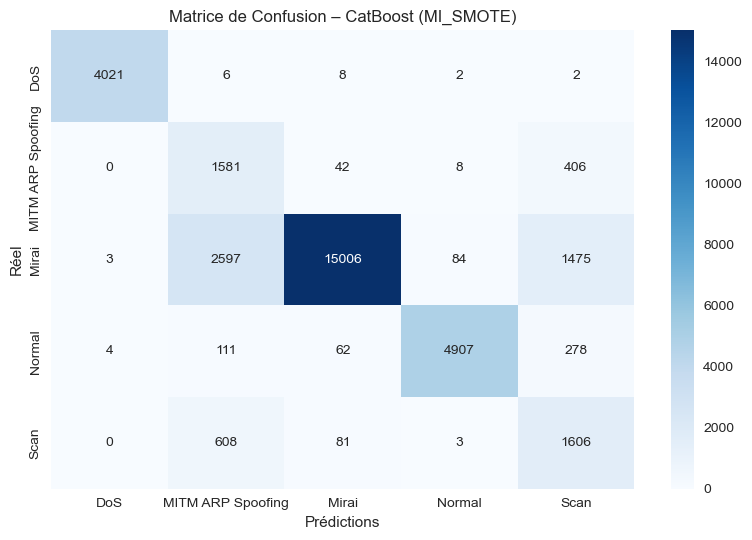

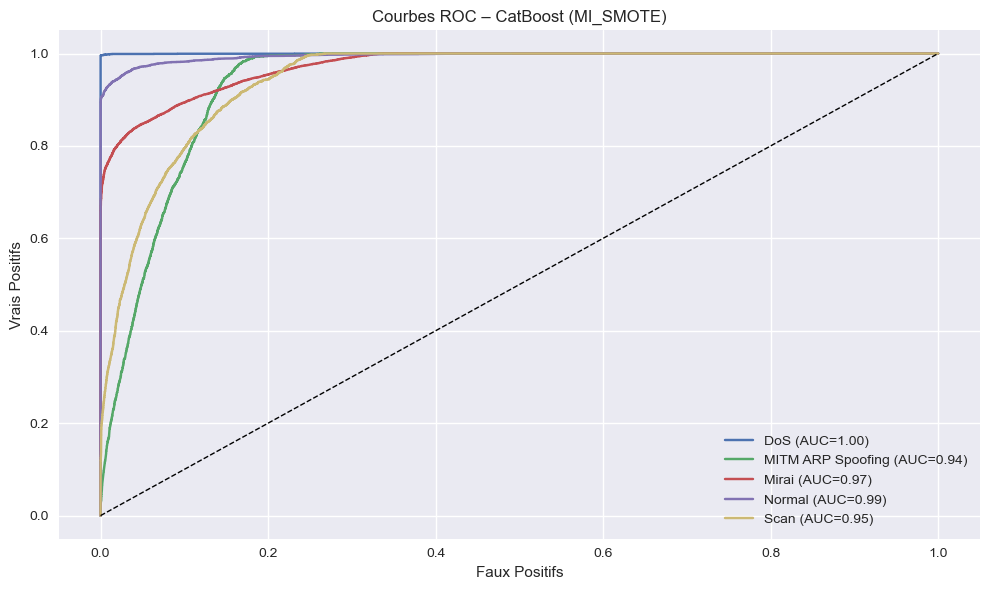


 Rapport de test, matrice et courbe ROC enregistrés pour : MI_SMOTE

 Entraînement CatBoost sur : LASSO_SMOTE

 Moyennes CV [ LASSO_SMOTE ] :

fold               5.5000
accuracy           0.8534
f1_macro           0.8572
precision_macro    0.8685
recall_macro       0.8534
dtype: float64


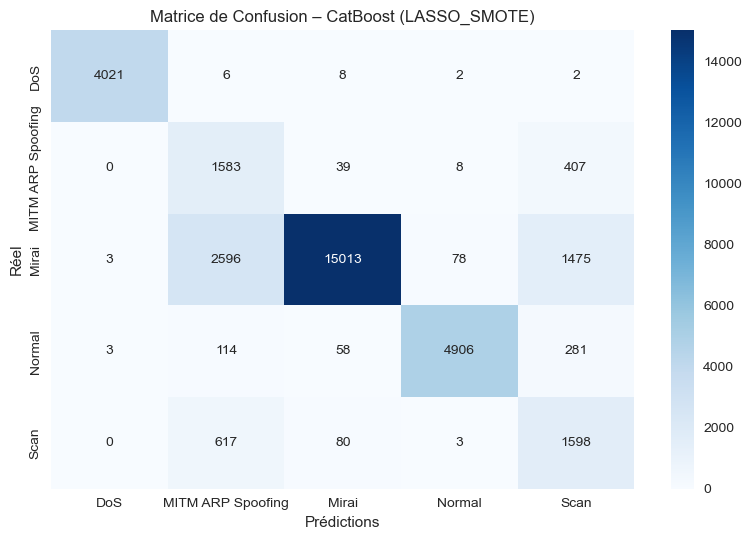

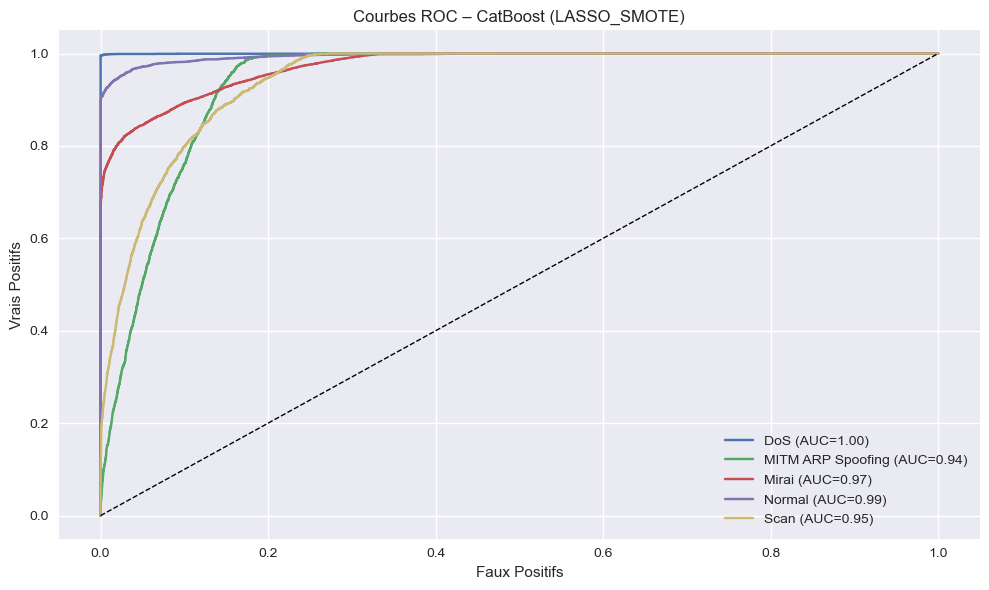


 Rapport de test, matrice et courbe ROC enregistrés pour : LASSO_SMOTE

 Entraînement CatBoost sur : INTER_SMOTE

 Moyennes CV [ INTER_SMOTE ] :

fold               5.5000
accuracy           0.8537
f1_macro           0.8576
precision_macro    0.8687
recall_macro       0.8537
dtype: float64


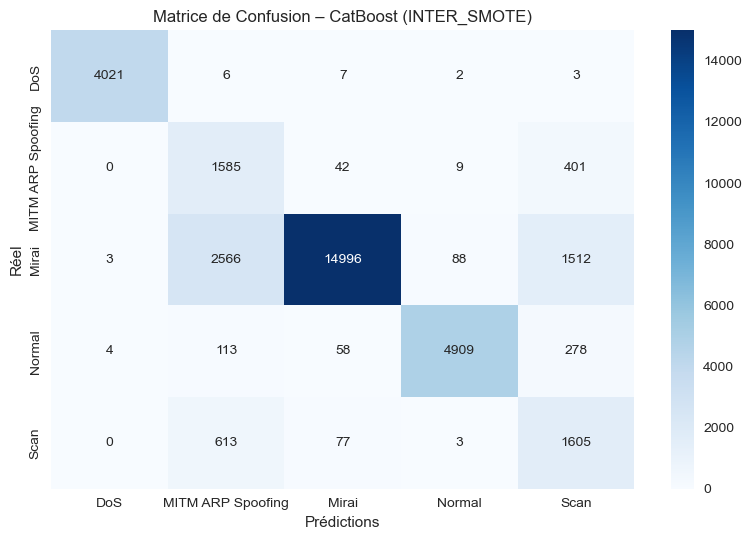

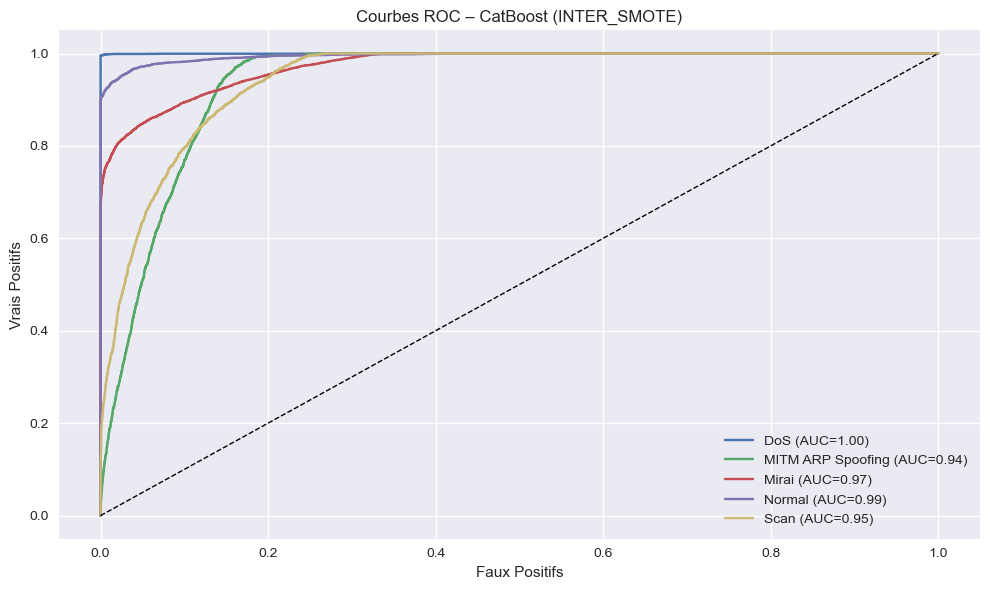


 Rapport de test, matrice et courbe ROC enregistrés pour : INTER_SMOTE

 Entraînement CatBoost sur : MI_RUS

 Moyennes CV [ MI_RUS ] :

fold               5.5000
accuracy           0.8374
f1_macro           0.8420
precision_macro    0.8545
recall_macro       0.8374
dtype: float64


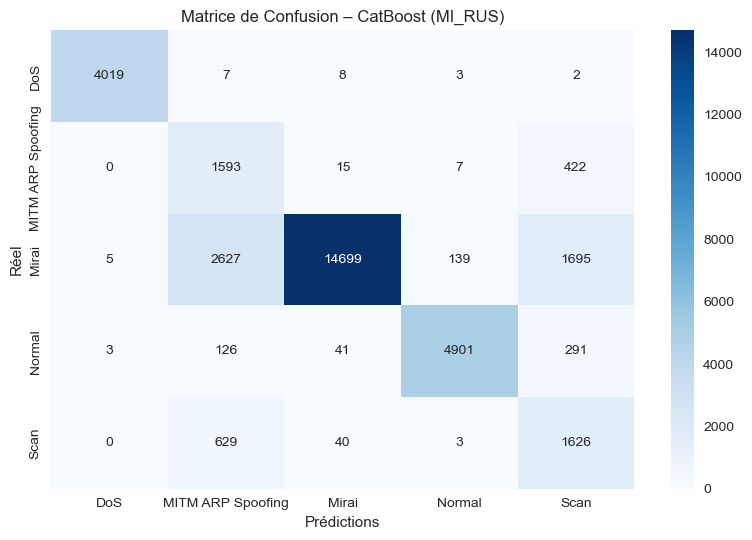

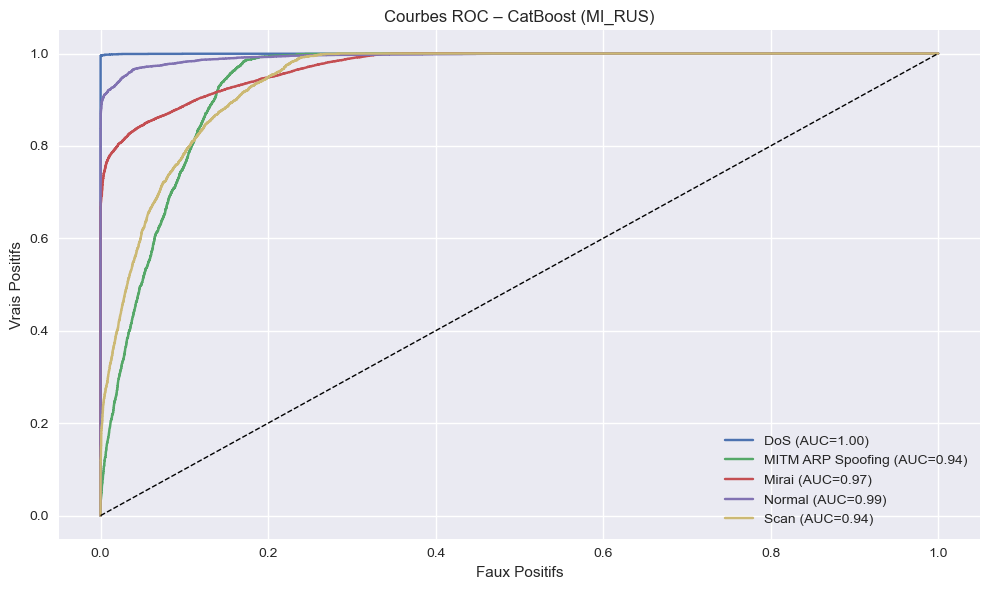


 Rapport de test, matrice et courbe ROC enregistrés pour : MI_RUS

 Entraînement CatBoost sur : LASSO_RUS

 Moyennes CV [ LASSO_RUS ] :

fold               5.5000
accuracy           0.8379
f1_macro           0.8425
precision_macro    0.8553
recall_macro       0.8379
dtype: float64


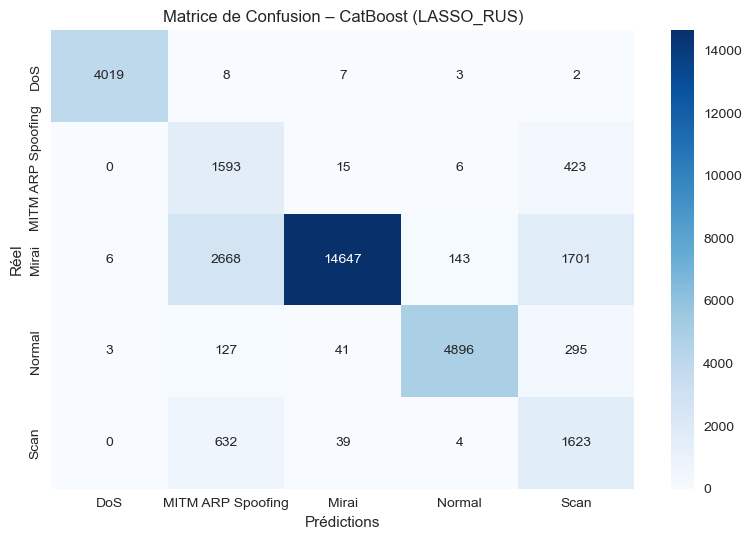

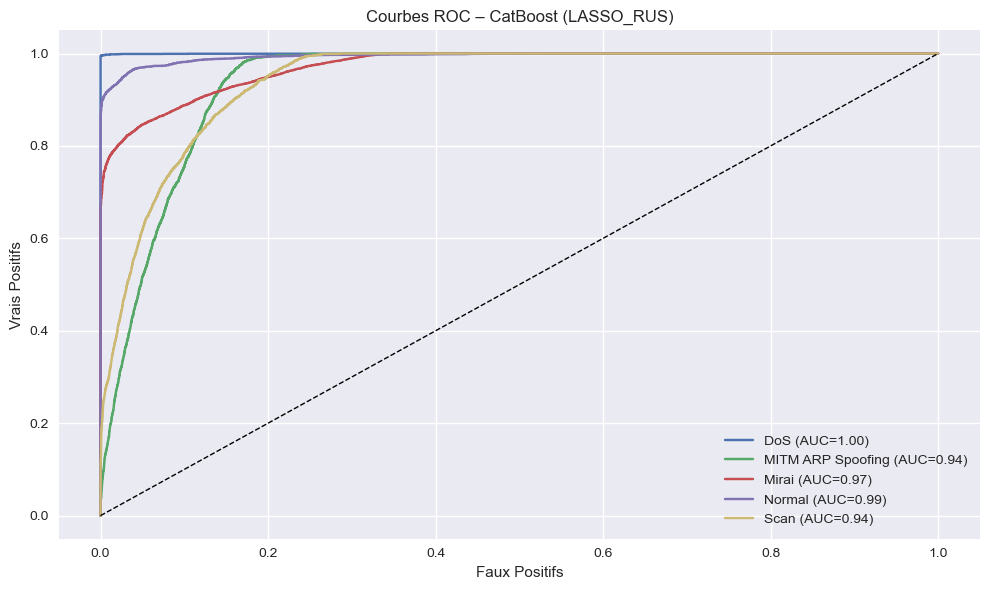


 Rapport de test, matrice et courbe ROC enregistrés pour : LASSO_RUS

 Entraînement CatBoost sur : INTER_RUS

 Moyennes CV [ INTER_RUS ] :

fold               5.5000
accuracy           0.8384
f1_macro           0.8429
precision_macro    0.8555
recall_macro       0.8384
dtype: float64


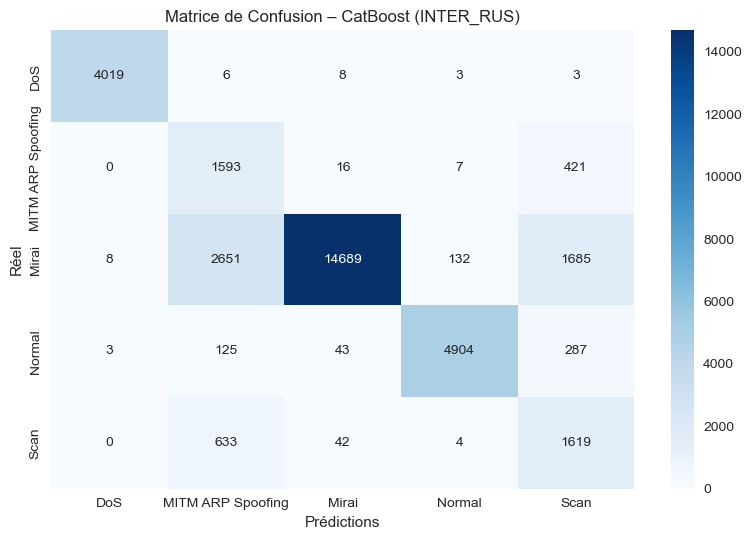

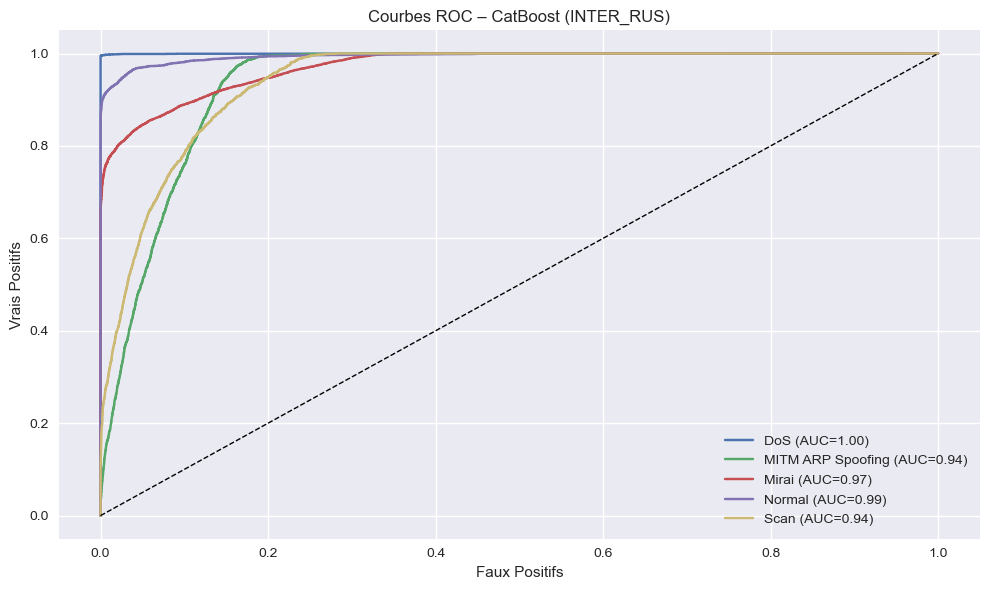


 Rapport de test, matrice et courbe ROC enregistrés pour : INTER_RUS


In [29]:
model_cb = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=3,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    random_seed=RANDOM_STATE,
    verbose=False
)
#  Fonction d'évaluation complète 
def evaluate_model(name, X_train, y_train, X_test, y_test):
    print(f"\n\033[1m Entraînement CatBoost sur : {name}\033[0m")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    metrics_cv = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model_cb.fit(X_tr, y_tr)
        y_val_pred = model_cb.predict(X_val)

        metrics_cv.append({
            'fold': fold,
            'accuracy': accuracy_score(y_val, y_val_pred),
            'f1_macro': f1_score(y_val, y_val_pred, average='macro'),
            'precision_macro': precision_score(y_val, y_val_pred, average='macro'),
            'recall_macro': recall_score(y_val, y_val_pred, average='macro')
        })

    cv_df = pd.DataFrame(metrics_cv)
    cv_df.to_csv(f"metrics_cv_catboost_{name}.csv", index=False)
    print(f"\n Moyennes CV [ {name} ] :\n")
    print(cv_df.mean(numeric_only=True).round(4))

    # Test final 
    model_cb.fit(X_train, y_train)
    model_cb.save_model("model_catboost.cbm")

    y_pred_test = model_cb.predict(X_test)
    y_proba_test = model_cb.predict_proba(X_test)

    #  matrice de confusion
    report = classification_report(y_test, y_pred_test, target_names=class_names, output_dict=True)
    with open(f"classification_report_catboost_{name}.json", "w") as f:
        json.dump(report, f, indent=4)

    conf_mat = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Matrice de Confusion – CatBoost ({name})")
    plt.xlabel("Prédictions")
    plt.ylabel("Réel")
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_catboost_{name}.png", dpi=300)
    plt.show()

    # ROC multiclasses
    y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_test[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC={roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title(f"Courbes ROC – CatBoost ({name})")
    plt.xlabel("Faux Positifs")
    plt.ylabel("Vrais Positifs")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"roc_curve_catboost_{name}.png", dpi=300)
    plt.show()

    print(f"\n Rapport de test, matrice et courbe ROC enregistrés pour : {name}")


#  Enchaînement sur tous les jeux 
datasets = {
    "MI_SMOTE": (X_train_MI, y_train_SMOTE_df, X_test_MI, y_test),
    "LASSO_SMOTE": (X_train_LASSO, y_train_SMOTE_df, X_test_LASSO, y_test),
    "INTER_SMOTE": (X_train_MI_LASSO, y_train_SMOTE_df, X_test_MI_LASSO, y_test),
    "MI_RUS": (X_train_MI_rus, y_train_rus_df, X_test_MI_rus, y_test),
    "LASSO_RUS": (X_train_LASSO_rus, y_train_rus_df, X_test_LASSO_rus, y_test),
    "INTER_RUS": (X_train_MI_LASSO_rus, y_train_rus_df, X_test_MI_LASSO_rus, y_test)
}

for name, (X_tr, y_tr, X_te, y_te) in datasets.items():
    evaluate_model(name, X_tr, y_tr, X_te, y_te)


modele snn

In [35]:

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import label_binarize
import joblib
print("\n\033[1m  SNN \033[0m")


# Modèle SNN 
model_snn = MLPClassifier(
    hidden_layer_sizes=(124, 37),
    activation='relu',
    solver='adam',
    alpha=2.5700075406535323e-05,
    batch_size=119,
    learning_rate_init=0.0008530946346381983,
    max_iter=500,
    random_state=RANDOM_STATE
)


  SNN 


In [37]:
def evaluate_snn(name, X_train, y_train, X_test, y_test):
    print(f"\n\033[1m Entraînement SNN sur : {name}\033[0m")
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    metrics_cv = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model_snn.fit(X_tr, y_tr)
        y_pred_val = model_snn.predict(X_val)

        metrics_cv.append({
            'fold': fold,
            'accuracy': accuracy_score(y_val, y_pred_val),
            'f1_macro': f1_score(y_val, y_pred_val, average='macro'),
            'precision_macro': precision_score(y_val, y_pred_val, average='macro'),
            'recall_macro': recall_score(y_val, y_pred_val, average='macro')
        })

    cv_df = pd.DataFrame(metrics_cv)
    cv_df.to_csv(f"metrics_cv_snn_{name}.csv", index=False)
    print(f"\n Moyennes CV [ {name} – SNN ] :\n")
    print(cv_df.mean(numeric_only=True).round(4))

    # Test final
    model_snn.fit(X_train, y_train)
    joblib.dump(model_snn, "model_snn_optimized.pkl")
    y_pred_test = model_snn.predict(X_test)
    y_proba_test = model_snn.predict_proba(X_test)

    # Rapport
    report = classification_report(y_test, y_pred_test, target_names=class_names, output_dict=True)
    with open(f"classification_report_snn_{name}.json", "w") as f:
        json.dump(report, f, indent=4)

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix – SNN ({name})")
    plt.xlabel("Prédictions")
    plt.ylabel("Réel")
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_snn_{name}.png", dpi=300)
    plt.close()

    # ROC multiclasses
    y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_test[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC={roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title(f"Courbes ROC – SNN ({name})")
    plt.xlabel("Faux positifs")
    plt.ylabel("Vrais positifs")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"roc_curve_snn_{name}.png", dpi=300)
    plt.close()

    print(f" Évaluation terminée pour {name}")


In [39]:
datasets = {
    "MI_SMOTE": (X_train_MI, y_train_SMOTE_df, X_test_MI, y_test),
    "LASSO_SMOTE": (X_train_LASSO, y_train_SMOTE_df, X_test_LASSO, y_test),
    "INTER_SMOTE": (X_train_MI_LASSO, y_train_SMOTE_df, X_test_MI_LASSO, y_test),
    "MI_RUS": (X_train_MI_rus, y_train_rus_df, X_test_MI_rus, y_test),
    "LASSO_RUS": (X_train_LASSO_rus, y_train_rus_df, X_test_LASSO_rus, y_test),
    "INTER_RUS": (X_train_MI_LASSO_rus, y_train_rus_df, X_test_MI_LASSO_rus, y_test)
}

for name, (X_tr, y_tr, X_te, y_te) in datasets.items():
    evaluate_snn(name, X_tr, y_tr, X_te, y_te)



 Entraînement SNN sur : MI_SMOTE

 Moyennes CV [ MI_SMOTE – SNN ] :

fold               5.5000
accuracy           0.8411
f1_macro           0.8449
precision_macro    0.8563
recall_macro       0.8411
dtype: float64
 Évaluation terminée pour MI_SMOTE

 Entraînement SNN sur : LASSO_SMOTE

 Moyennes CV [ LASSO_SMOTE – SNN ] :

fold               5.5000
accuracy           0.8413
f1_macro           0.8451
precision_macro    0.8569
recall_macro       0.8413
dtype: float64
 Évaluation terminée pour LASSO_SMOTE

 Entraînement SNN sur : INTER_SMOTE

 Moyennes CV [ INTER_SMOTE – SNN ] :

fold               5.5000
accuracy           0.8406
f1_macro           0.8445
precision_macro    0.8558
recall_macro       0.8406
dtype: float64
 Évaluation terminée pour INTER_SMOTE

 Entraînement SNN sur : MI_RUS

 Moyennes CV [ MI_RUS – SNN ] :

fold               5.5000
accuracy           0.8183
f1_macro           0.8226
precision_macro    0.8353
recall_macro       0.8183
dtype: float64
 Évaluation terminée 